We will implement a text segmentation algorithm. The algorithm is based on the following steps:
1. Preprocess the text so that we have a list of Sentence objects
2. Calculate the cohesion for each pair of adjacent sentences
3. Find Sentences where the topic changes based on the cohesion scores: highest cohesion drops or lowest cohesion scores
4. Move Block boundaries to the topic change points and return them. The Blocks will represent coherent sections of the text.

In [115]:
from enum import Enum
from typing import List, Tuple
import numpy as np
from string import punctuation
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import spacy

spacy.cli.download("en_core_web_md")
spacy_vectorizer = spacy.load("en_core_web_md")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


### Classes used for representing sentences and block of sentences

In [116]:
class Sentence:
    def __init__(self, text: str, words: List[str]):
        self.text = text
        self.words = words
        
    def __eq__(self, other):
        return self.text == other.text
        
    def __repr__(self):
        return self.text
    
class Block:
    def __init__(self, sentences: List[Sentence]):
        self.sentences = sentences
        
    def __len__(self):
        return len(self.sentences)
    
    def __eq__(self, other):
        if len(self.sentences) != len(other.sentences):
            return False
        # true if all sentences equal
        return all([self.sentences[i] == other.sentences[i] for i in range(len(self.sentences))])
        
    def __repr__(self):
        return " ".join([sentence.text for sentence in self.sentences])
    
    def get_string_sentences(self) -> List[str]:
        return [" ".join(sentence.words) for sentence in self.sentences]

### Retrieve input texts

In [117]:
# retrieve text from res/mixed_texts.txt
with open('res/mixed_texts.txt', 'r') as file:
    raw_text = file.read()

### 1. Preprocess the text

In [118]:
def preprocess_text(text: str) -> Tuple[List[Sentence], List[int]]:
    """
    Preprocess the text by splitting it into sentences, removing stopwords and punctuation, and lemmatizing the words.
    :param text: the text to be preprocessed
    :return: a list of Sentence objects and a list of correct indexes of topic changes (the last sentence index of each topic)
    """
    # get the list of stopwords
    stopwords_list = stopwords.words('english')
    
    sentence_list: List[Sentence] = []
    
    # list to store indexes of topic changes, i.e. the last sentence index of each topic
    topic_changes: List[int] = []
    
    # split the text into sentences
    sentences = nltk.sent_tokenize(text)
    
    # remove stopwords and punctuation
    for sentence in sentences:
        relevant_words = [word.lower() for word in nltk.word_tokenize(sentence) if word.lower() not in stopwords_list and word not in punctuation]
        # lemmatize relevant words
        lemmatizer = nltk.WordNetLemmatizer()
        relevant_words = [lemmatizer.lemmatize(word) for word in relevant_words]
        sentence_list.append(Sentence(sentence, relevant_words))
    
    # find indexes of topic change. the topic change is indicated by the "<CHANGE>" token
    # the "<CHANGE>" token is considered as a separate sentence, so we remove it from the sentence list and store the index of the previous sentence (i.e. the last sentence of the previous topic)
    for i, sentence in enumerate(sentence_list):
        if "<CHANGE>" in sentence.text:
            topic_changes.append(i-1)
            sentence_list.remove(sentence)     
    return sentence_list, topic_changes

### 2. Calculate adjacent sentences cohesion

We will calculate the cohesion between each pair of adjacent sentences. We tested three methods for calculating cohesion:
1. **TF-IDF**: Calculate the cosine similarity between the TF-IDF vectors of adjacent sentences.
2. **Overlap**: Calculate the overlap of words between adjacent sentences.
3. **Spacy**: Calculate the similarity between the Spacy vectors of adjacent sentences.

In [119]:
class CohesionMethod(Enum):
    TF_IDF = "tf_idf"
    OVERLAP = "overlap"
    SPACY = "spacy"

def calculate_cohesion(sentences: List[Sentence], method: CohesionMethod = CohesionMethod.SPACY) -> List[float]:
    """
    Calculate the cohesion between adjacent sentences based on the chosen method.
    :param sentences: List of Sentence objects.
    :param method: Method to use for calculating cohesion.
    :return: List of cohesion scores between adjacent sentences.
    """
    match method:
        case CohesionMethod.TF_IDF:
            return cohesion_tf_idf(sentences)
        case CohesionMethod.OVERLAP:
            return cohesion_overlap(sentences)
        case CohesionMethod.SPACY:
            return cohesion_spacy(sentences)

In [120]:
def cohesion_tf_idf(sentences: List[Sentence]) -> List[float]:
    """
    Calculate the cohesion between adjacent sentences based on the cosine similarity of their TF-IDF vectors.
    """
    # TF-IDF vectorization
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform([" ".join(sentence.words) for sentence in sentences])

    # Calculate cosine similarity between adjacent sentences
    cohesion_scores = []
    for i in range(len(sentences) - 1):
        sim_score = cosine_similarity(tfidf_matrix[i], tfidf_matrix[i+1])
        cohesion_scores.append(sim_score[0][0])

    return cohesion_scores

In [121]:
def cohesion_overlap(sentences: List[Sentence]) -> List[float]:
    """
    Calculate the cohesion between adjacent sentences based on the overlap of words.
    """
    sentence_list = [sentence.words for sentence in sentences]

    scores = []
    for i in range(len(sentence_list)-1):
        set1 = set(sentence_list[i])
        set2 = set(sentence_list[i+1])
        intersection = len(set1.intersection(set2))
        score = intersection / (len(set1) + len(set2) - intersection)
        scores.append(score)
    return scores

In [122]:
def cohesion_spacy(sentences: List[Sentence]) -> List[float]:
    """
    Calculate the cohesion between adjacent sentences based on the similarity of their Spacy vectors.
    """
    cohesion_scores = []
    
    for i in range(len(sentences) - 1):
        doc1 = spacy_vectorizer(" ".join(sentences[i].words))
        doc2 = spacy_vectorizer(" ".join(sentences[i+1].words))
        sim_score = doc1.similarity(doc2)
        cohesion_scores.append(sim_score)

    return cohesion_scores

Quick test of cohesion calculation

In [123]:
text = "This is a sample text. It demonstrates how to calculate intra-document cohesion between sentences. Intra-document cohesion is important for understanding the coherence of a document."
sentences, topic_changes_indexes = preprocess_text(text)

for method in CohesionMethod:
    cohesion_scores = calculate_cohesion(sentences, method)
    print(f"{method.value.capitalize()} cohesion scores:", cohesion_scores)

Tf_idf cohesion scores: [0.0, 0.4179779031144455]
Overlap cohesion scores: [0.0, 0.2222222222222222]
Spacy cohesion scores: [0.4905806410251649, 0.9547883674863402]


Saving sentences list, topic changes indexes and cohesion scores for the text since we will use them later and we don't need to change them.

In [124]:
MAIN_SENT_LIST, MAIN_TOPIC_CHANGES_INDEXES = preprocess_text(raw_text)
MAIN_COHESION_SCORES = calculate_cohesion(MAIN_SENT_LIST, CohesionMethod.SPACY)

#### Plotting function
We define a function to plot the cohesion scores and highlight the topic change points.
We can also provide and highlight the topic change points that were found by the algorithm, in order to compare them with the actual topic change points.

In [125]:
def plot_text_segmentation(cohesion_scores: List[float], topic_changes_indexes: List[int], topic_changes_found: List[int] = None):
    """
    Plot the cohesion scores between sentences and highlight the topic change points. If topic_changes_found is provided, highlight them as well.
    :param cohesion_scores: List of cohesion scores between sentences.
    :param topic_changes_indexes: List of indexes of correct topic changes.
    :param topic_changes_found: List of indexes of topic changes found by an algorithm.
    """
    plt.plot(cohesion_scores)
    plt.xlabel("Sentence number")
    plt.ylabel("Cohesion score")
    # plt.xticks(range(0, len(cohesion_scores), 3))
    plt.xticks(range(len(cohesion_scores)))
    for i in topic_changes_indexes:
        plt.axvline(x=i, color='r', linestyle='-')
    if topic_changes_found:
        for i in topic_changes_found:
            plt.axvline(x=i, color='g', linestyle='dotted')
    plt.show()

Plot the cohesion scores and highlight the correct topic change points

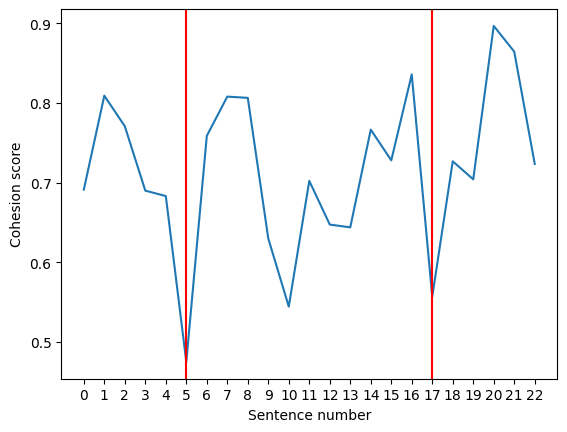

Last sentence index of topic: 5
Sentence: Mussolini denounced the PSI, his views now were centering on Italian nationalism instead of socialism, and used his newspaper, Il Popolo d'Italia, to promote the war.
Cohesion score: 0.4746724733147802

Last sentence index of topic: 17
Sentence: Below are the Bible verses and Scriptures that both prophesize the resurrection of Jesus and testify of the reality of the resurrected body of Christ.
Cohesion score: 0.5566012625374582


In [126]:
plot_text_segmentation(MAIN_COHESION_SCORES, MAIN_TOPIC_CHANGES_INDEXES)
# for each topic change, print the corresponding sentence
for i in MAIN_TOPIC_CHANGES_INDEXES:
    print(f"Last sentence index of topic: {i}")
    print(f"Sentence: {MAIN_SENT_LIST[i]}")
    print(f"Cohesion score: {MAIN_COHESION_SCORES[i]}\n")

### 3. Find sentences where the topic changes

We will now look for the sentences where the topic changes. In particular we look for the last sentence of each topic. We considered two methods for finding topic change points:
1. **Drops**: Identify the indices for topic change points based on the highest drops in cohesion scores.
2. **Min cohesion**: Identify the indices for topic change points based on the lowest cohesion scores.

In [127]:
class ChangePointsMethod(Enum):
    DROPS = "drops"
    MIN_COHESION = "min_cohesion" 

def find_topic_change_points(cohesion_scores: List[float], num_splits: int, 
                             method: ChangePointsMethod = ChangePointsMethod.DROPS) -> List[int]:
    """
    Identify the indices for topic change points based on the chosen method.
    :param cohesion_scores: List of cohesion scores between sentences.
    :param num_splits: Number of splits (topic changes) to make.
    :param method: Method to use for finding topic change points.
    :return: Last sentence index of each topic.
    """
    
    match method:
        case ChangePointsMethod.DROPS:
            return find_topic_change_points_drops(cohesion_scores, num_splits)
        case ChangePointsMethod.MIN_COHESION:
            return find_topic_change_points_min_cohesion(cohesion_scores, num_splits)

In [128]:
def find_topic_change_points_drops(cohesion_scores: List[float], num_splits: int) -> List[int]:
    """
    Identify the indices for topic change points based on the highest drops in cohesion scores.
    """
    # calculate drops in cohesion scores
    drops = [cohesion_scores[i-1] - cohesion_scores[i] + cohesion_scores[i+1] for i in range(1, len(cohesion_scores)-1)]

    # drop indexes sorted in ascending order
    drops_indexes_sorted_asc = np.argsort(drops)

    # deepest num_splits drop indexes, sorted in ascending order
    deepest_drops_indexes_sorted_asc = drops_indexes_sorted_asc[-num_splits+1:] # +1 to exclude one drop (3 topic -> 2 cp -> 2 drops)
    # sort the deepest drops indexes in ascending order
    change_points = np.sort(deepest_drops_indexes_sorted_asc)

    return [cp + 1 for cp in change_points]  # Adjust indices to point to sentences after the drops.

In [129]:
def find_topic_change_points_min_cohesion(cohesion_scores: List[float], num_splits: int) -> List[int]:
    """
    Identify the indices for topic change points based on the lowest cohesion scores.
    """
    # cohesion scores indexes sorted in ascending order
    cohesion_scores_indexes_sorted_asc = np.argsort(cohesion_scores)

    # lowest cohesion scores indexes
    lowest_cs_indexes = cohesion_scores_indexes_sorted_asc[:num_splits-1]

    # sort the lowest cohesion scores indexes in ascending order
    change_points = np.sort(lowest_cs_indexes)

    return [cp for cp in change_points]  # Adjust indices to point to sentences after the drops.

### 4. Move Block boundaries to the topic change points

We will now create new blocks based on the identified topic change points. Each change point will indicate the last sentence of a block, so we will move the block boundaries accordingly.

In [130]:
def move_block_boundaries(sentences: List[Sentence], change_points: List[int]) -> List[Block]:
    """
    Create new blocks based on the identified topic change points.
    :param sentences: List of all sentences.
    :param change_points: Indices of sentences indicating topic changes.
    :return: New list of blocks adjusted for topic changes.
    """
    blocks = []
    start_index = 0 # index of the first sentence in the currently iterated block
    for cp in change_points:
        new_block = Block(sentences[start_index:cp+1]) # cp corresponds to the last sentence of the block, should be included
        blocks.append(new_block)
        start_index = cp+1
    # add the last block
    last_block = Block(sentences[start_index:])
    blocks.append(last_block)
    return blocks

### Final text segmentation function

In [131]:
def text_segmentation(text: str, num_blocks: int = 3, 
                cohesion_method: CohesionMethod = CohesionMethod.SPACY,
                change_points_method: ChangePointsMethod = ChangePointsMethod.DROPS) -> Tuple[List[Block], List[int]]:
    """
    Segment the text into coherent sections.
    1. Preprocess the text so that we have a list of Sentence objects
    2. Calculate the cohesion for each pair of adjacent sentences
    3. Find Sentences where the topic changes
    4. Move Block boundaries to the topic change points
    5. Return the Blocks and the indexes of topic changes (the last sentence index of each topic)
    :param text: the text to be segmented
    :param num_blocks: the number of Blocks to split the text into
    :param cohesion_method: the method to use for calculating cohesion
    :param change_points_method: the method to use for finding topic change points
    :return: a list of Blocks and a list of indexes of topic changes (the last sentence index of each topic)
    """
    
    # preprocess the text
    sentences, _ = preprocess_text(text)

    # calculate cohesion scores between adjacent sentences
    cohesion_scores: List[float] = calculate_cohesion(sentences, cohesion_method)
    
    # find blocks of text where the topic changes
    change_points = find_topic_change_points(cohesion_scores, num_blocks, change_points_method)
    
    # move block boundaries to the topic change points
    new_blocks = move_block_boundaries(sentences, change_points)
        
    return new_blocks, change_points

### Test the text segmentation function

We found that the best results are obtained by using the Spacy method for calculating cohesion and the Drops method for finding topic change points.

In [132]:
blocks, change_points = text_segmentation(raw_text)
for i, block in enumerate(blocks):
    print(f"Block {i+1}:")
    for sentence in block.sentences:
        print(sentence)
    print()

Block 1:
Benito Amilcare Andrea Mussolini was an Italian dictator who founded and led the National Fascist Party (PNF).
He was Prime Minister of Italy from the March on Rome in 1922 until his deposition in 1943, as well as Duce of Italian fascism from the establishment of the Italian Fasces of Combat in 1919 until his summary execution in 1945 by Italian partisans.
As dictator of Italy and principal founder of fascism, Mussolini inspired and supported the international spread of fascist movements during the inter-war period.
In 1912, Mussolini became a member of the National Directorate of the Italian Italian Socialist Party (PSI).
In 1914, Mussolini founded a newspaper, Il Popolo d'Italia, and served in the Royal Italian Army during the war until he was wounded and discharged in 1917.
Mussolini denounced the PSI, his views now were centering on Italian nationalism instead of socialism, and used his newspaper, Il Popolo d'Italia, to promote the war.

Block 2:
The Resurrection of Jesus 

Plot the cohesion scores and highlight the correct topic change points (red) and the topic change points found by the algorithm (green).

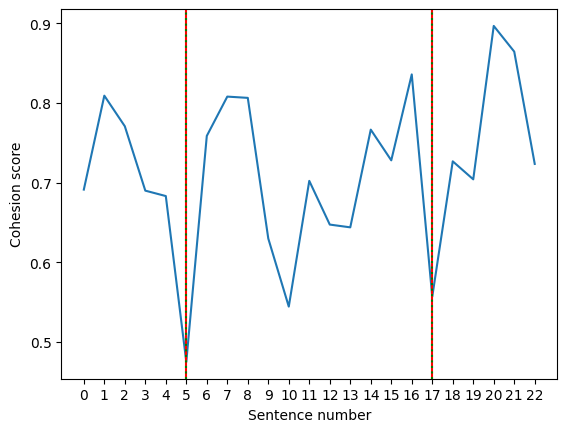

In [133]:
plot_text_segmentation(MAIN_COHESION_SCORES, MAIN_TOPIC_CHANGES_INDEXES, change_points)